In [ ]:
import pandas as pd
import os
import os.path as path
import sys
import matplotlib.pyplot as plt
import io
import time
from IPython.display import display
from time import strftime, gmtime
import numpy as np
from datetime import date

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from xgboost import plot_importance
import xgboost as xgb

%matplotlib inline

sys.path.insert(0, path.abspath(path.join(os.getcwd() ,"..", 'code')))
from utils import show_me_basic_stats, array_to_deciles, timer, normalise_data

In [2]:
data_path = '../data/'

In [3]:
# data in folder 
os.listdir(data_path)

['deciles.csv',
 'features.png',
 'rev-devices.csv',
 'rev-notifications.csv',
 'rev-transactions.csv',
 'rev-users.csv']

 ## Data Exploration

### Create basic stats for all the available features to get a better understanding of the data

In [4]:
df_devices = pd.read_csv(data_path+'rev-devices.csv')
pd.set_option('display.max_columns', 500)
df_devices.head()

,brand,user_id
0,Android,user_3257
1,Apple,user_6809
2,Android,user_9144
3,Apple,user_3636
4,Android,user_5970


In [5]:
df_notif = pd.read_csv(data_path+'rev-notifications.csv')
pd.set_option('display.max_columns', 500)
df_notif.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


In [6]:
df_trans = pd.read_csv(data_path+'rev-transactions.csv')
pd.set_option('display.max_columns', 500)
df_trans.head()

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652


In [7]:
df_users = pd.read_csv(data_path+'rev-users.csv')
pd.set_option('display.max_columns', 500)
df_users.head()

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0


,birth_year,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
count,19430.000000,19430.000000,12820.000000,12820.000000,19430.000000,19430.0,19430.0
mean,1983.648636,0.181009,0.947582,0.895944,17.887699,0.0,0.0
std,11.368871,0.385035,0.222877,0.305345,46.506438,0.0,0.0
min,1929.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1978.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0
50%,1986.000000,0.000000,1.000000,1.000000,5.000000,0.0,0.0
75%,1992.000000,0.000000,1.000000,1.000000,19.000000,0.0,0.0
max,2001.000000,1.000000,1.000000,1.000000,2918.000000,0.0,0.0


col_0,% observations
country,
AT,0.004014
AU,0.000309
BE,0.007360
BG,0.004838
CH,0.022800
CY,0.009830
CZ,0.018271
DE,0.022954
DK,0.005198


col_0,% observations
city,
's Hertogenbosch,0.000051
1000 Bruxelles,0.000051
1030,0.000051
1050 Wien,0.000051
10967/Berlin,0.000051
1120,0.000051
1256 Troinex,0.000051
14612 Falkensee,0.000051
21000,0.000051


col_0,% observations
plan,
METAL,0.026094
METAL_FREE,0.001904
PREMIUM,0.044519
PREMIUM_FREE,0.000206
PREMIUM_OFFER,0.001287
STANDARD,0.925991


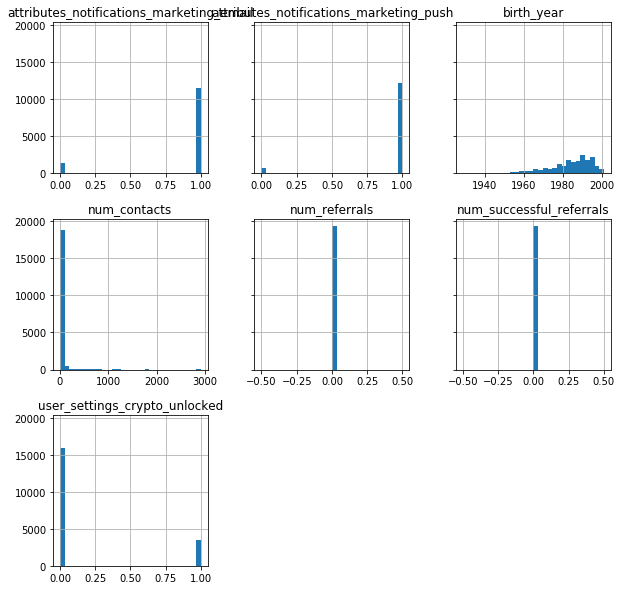

In [8]:
show_me_basic_stats(df_users, cols_to_exclude=['user_id', 'created_date'])

We can see some things here:
- `num_referrals`, `num_successful_referrals` are all zeros so not a usefull feature, we can drop it
- `City`: takes on too many unique values to be of any practical use.  It's possible to play a bit with the text and merge stuff but let's leave it for now as `Country` seems usefull.
- `Birth year`: as expected our data are a bit skewed towards younger people

,amount_usd,ea_merchant_mcc
count,2.740075e+06,1.581417e+06
mean,1.703225e+05,5.699736e+03
std,9.634014e+07,9.493660e+02
min,0.000000e+00,7.420000e+02
25%,2.030000e+00,5.411000e+03
50%,8.510000e+00,5.812000e+03
75%,2.822000e+01,5.921000e+03
max,8.510645e+10,9.406000e+03


col_0,% observations
transactions_type,
ATM,0.034187
CARD_PAYMENT,0.538591
CARD_REFUND,0.004366
CASHBACK,0.030214
EXCHANGE,0.058082
FEE,0.008634
REFUND,0.000545
TAX,0.001032
TOPUP,0.141723


col_0,% observations
transactions_currency,
AED,0.001377
AUD,0.006157
BCH,0.000119
BGN,0.000094
BTC,0.001214
CAD,0.003201
CHF,0.014494
CZK,0.016412
DKK,0.005131


col_0,% observations
transactions_state,
CANCELLED,0.000605
COMPLETED,0.878796
DECLINED,0.056672
FAILED,0.014982
PENDING,0.007844
REVERTED,0.041100


col_0,% observations
ea_cardholderpresence,
FALSE,0.812664
TRUE,0.183812
UNKNOWN,0.003525


col_0,% observations
ea_merchant_city,
""".""",6.323987e-07
# Poznan,6.323987e-07
#05-12 Bugis,6.323987e-07
#272;a Nang,4.426791e-06
$rhus C,1.264797e-06
$rhus C D,2.529595e-06
$rhus N,1.264797e-06
$rhus V,1.264797e-06
$stanbul,6.323987e-07


col_0,% observations
ea_merchant_country,
ABW,2.656385e-05
AGB,2.529891e-06
AGO,5.692254e-06
AIA,3.162363e-06
ALB,1.208023e-04
AND,3.586120e-04
ANT,1.897418e-06
APT,1.264945e-06
ARE,4.312199e-03


col_0,% observations
direction,
INBOUND,0.193528
OUTBOUND,0.806472


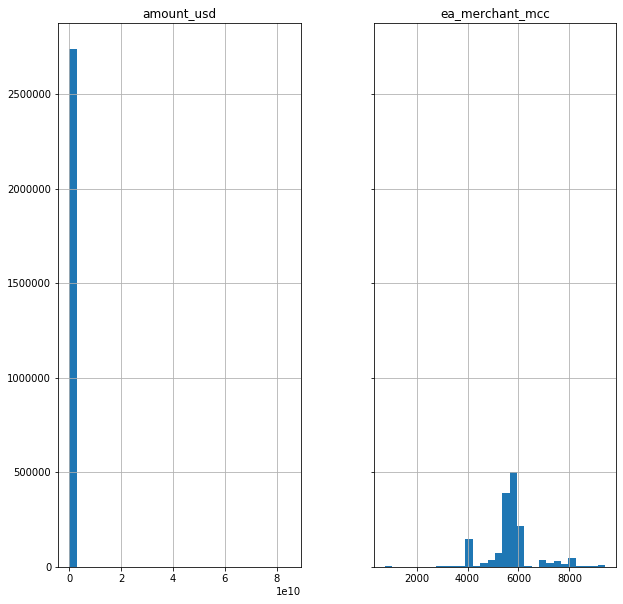

In [9]:
show_me_basic_stats(df_trans, cols_to_exclude=['user_id', 'transaction_id', 'created_date'])

Transactions Table:
- `amount_usd`: there some outliers very high amounts that we need to decide how we'll handle them.
- `ea_merchant_country`, `ea_merchant_city`: takes on too many unique values to be of any practical use. 
- `transactions_currency`: we need to group the currencies as it's mostly EUR nd GBP

In [10]:
show_me_basic_stats(df_notif, cols_to_exclude=['user_id', 'created_date'])

col_0,% observations
reason,
BLACK_FRIDAY,0.017313
ENGAGEMENT_SPLIT_BILL_RESTAURANT,0.018865
FIFTH_PAYMENT_PROMO,0.194914
JOINING_ANNIVERSARY,0.034134
LOST_CARD_ORDER,0.050454
MADE_MONEY_REQUEST_NOT_SPLIT_BILL,0.028782
METAL_GAME_START,0.068737
METAL_RESERVE_PLAN,0.010122
NO_INITIAL_CARD_ORDER,0.091419


col_0,% observations
channel,
EMAIL,0.502845
PUSH,0.473537
SMS,0.023618


col_0,% observations
status,
FAILED,0.265456
SENT,0.734544


In [11]:
show_me_basic_stats(df_devices, cols_to_exclude=['user_id'])

col_0,% observations
brand,
Android,0.499949
Apple,0.497838
Unknown,0.002213


Based on the previous analysis, we are going to exclude not informative features like: `ea_merchant_country`, `ea_merchant_city`, `num_referrals`, `num_successful_referrals`, `City`.
And we need to do some cleaning on the `amount_usd` feature, by dropping some oultiers before any modelling

### Define a target metric to measure user engagement. How would you define an engaged  vs. unengaged user

##### Assumptions:

Keep only OUTBOUND transactions as this shows actively use of the card by the person

In [12]:
# drop data and check again distribution of the features
print(len(df_trans))
df_trans =  df_trans[df_trans['direction'].isin(['OUTBOUND'])]
print(len(df_trans))

2740075
2209795


## History behind engagement measure: 😉

In the beginning I was planning to create an engagement metric as a combination of the average number of transcations per month per user and the average amount_usd per month per user. We do it per month, as we want the impact of time on the feature, to see how the behaviour changes using all the historic data available.

### However,
#### Benjamin said: “Daily usage is our key KPI”.
Based on that we'll go for daily usage, simple and powerful

##### Assumptions:

We have the following transactions and we'll assign them some meaning:
- CANCELLED (0.000750 of the cleaned data): transactions cancelled by the user. This means that the user decided not to procceed with the transaction. So we don't want these in the engagement measure. 
- COMPLETED	(0.891074): Transaction successfully completed - highest segment of interest  for our measure
- DECLINED	(0.068105): The user wanted to do the transaction but it was breaking rules and regulations so was stopped by us.
- FAILED (0.000086): The user wanted to do the transaction but there wasn't enough money in the account.
- PENDING (0.008804): we don't know what is going to happen with this transaction so we'll keep it for now.
- REVERTED (0.031181): same as cancelled more or less.

In conclusion we keep all transactions but the CANCELLED and the REVERTED as they show that the user didn't want to do the transaction

In [13]:
print(len(df_trans))
df_trans =  df_trans[~(df_trans['transactions_state'].isin(['CANCELLED','REVERTED']))]
print(len(df_trans))

2209795
2139234


In [14]:
# sanity check
df_trans['transactions_state'].value_counts()

COMPLETED    1969090
DECLINED      150498
PENDING        19456
FAILED           190
Name: transactions_state, dtype: int64

In [15]:
# calculate no of transactions per person per month

df_trans['created_date'] = pd.to_datetime(df_trans['created_date'])

df_trans_pm = df_trans.set_index('created_date')

# group by user_id and day, and count unique transactions
# then group by user id and calculate average transactions per day per user
df_trans_pm = df_trans_pm.groupby(['user_id',pd.Grouper(freq='D')]).transaction_id.nunique().reset_index().groupby(['user_id']).mean()

# log transform
df_trans_pm['trans_log'] = np.log(df_trans_pm)
df_trans_pm.columns = ['dau', 'log_dau']

,dau,log_dau
count,17842.000000,17842.000000
mean,2.132081,0.661496
std,1.087120,0.424660
min,1.000000,0.000000
25%,1.439394,0.364222
50%,1.921311,0.653008
75%,2.563910,0.941533
max,48.684211,3.885355


Still skewed? (log):  0.38868808005277256
Median (log):  0.6530075636841257
Still skewed?:  6.450956514842422
Median 1.9213106295149638


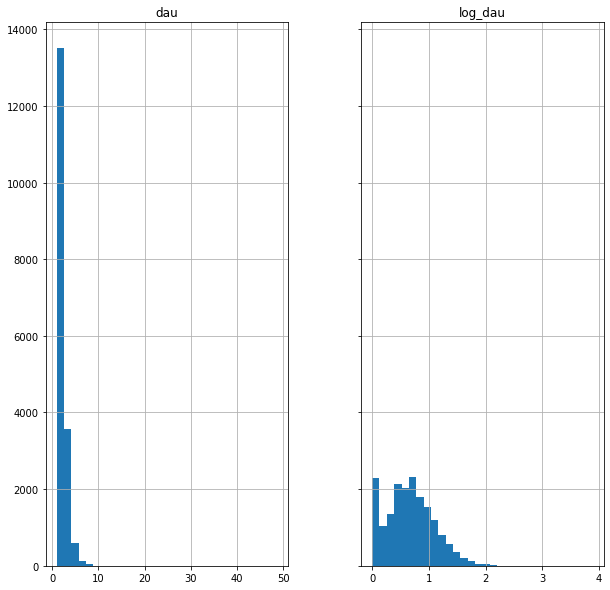

In [16]:
# Let's check the stats again
show_me_basic_stats(df_trans_pm.reset_index(), cols_to_exclude=['user_id'])

print("Still skewed? (log): ", df_trans_pm['log_dau'].skew())
print("Median (log): ", df_trans_pm['log_dau'].median())
print("Still skewed?: ", df_trans_pm['dau'].skew())
print("Median", df_trans_pm['dau'].median())

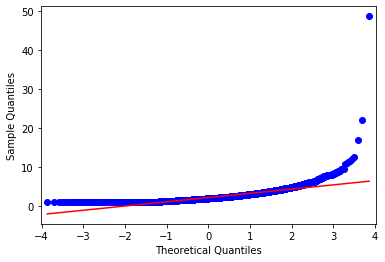

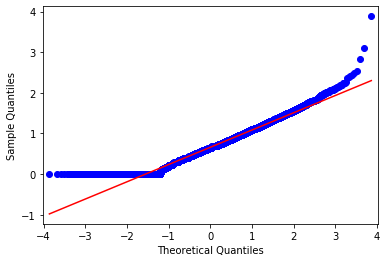

In [17]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df_trans_pm['dau'], line='s')
qqplot(df_trans_pm['log_dau'], line='s')
plt.show()

From the above visualisations we see the `dau` is very left skewed. By using the log of the `dau` we bring it closer to the normal distribution. So for now on we'll use the log transformation of the `dau` as the engagement measure.
Also, as themedia is very close to the mean value we'll take the median and what is less than the median are characterised as not engaged users and the rest as engaged (to avoid any class imbalance as well, chicky)

In [18]:
df_trans_pm['Target'] = np.where(df_trans_pm['log_dau'] < 0.65, False, True)
df_trans_pm['Target'].value_counts()

True     8980
False    8862
Name: Target, dtype: int64

## Build a model (heuristic/statistical/ML) to classify engaged  and unengaged

### Create features from each table on customer level

##### -------------- Notifications ----------------------------

In [19]:
# keep only successful notifications
print(len(df_notif))
df_notif = df_notif[df_notif['status']=='SENT']
print(len(df_notif))
df_notif.drop(columns = ['status'],inplace=True)

121813
89477


In [20]:
df_notif_user_lvl_reason = df_notif[['user_id', 'reason']].groupby(['user_id', 'reason']).size().unstack('reason')
df_notif_user_lvl_channel = df_notif[['user_id', 'channel']].groupby(['user_id', 'channel']).size().unstack('channel')

# join tables
df_notif_user_lvl = df_notif_user_lvl_reason.join(df_notif_user_lvl_channel)

In [21]:
df_notif_user_lvl.head()

,BLACK_FRIDAY,ENGAGEMENT_SPLIT_BILL_RESTAURANT,FIFTH_PAYMENT_PROMO,JOINING_ANNIVERSARY,LOST_CARD_ORDER,MADE_MONEY_REQUEST_NOT_SPLIT_BILL,METAL_GAME_START,METAL_RESERVE_PLAN,NO_INITIAL_CARD_ORDER,NO_INITIAL_CARD_USE,NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER,ONBOARDING_TIPS_ACTIVATED_USERS,PREMIUM_ENGAGEMENT_FEES_SAVED,PREMIUM_ENGAGEMENT_INACTIVE_CARD,PUMPKIN_PAYMENT_NOTIFICATION,REENGAGEMENT_ACTIVE_FUNDS,WELCOME_HOME,EMAIL,PUSH,SMS
user_id,,,,,,,,,,,,,,,,,,,,
user_0,1.0,NaN,2.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,6.0,NaN
user_1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
user_10,1.0,NaN,3.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN
user_100,NaN,NaN,2.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN
user_1000,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,5.0,10.0,1.0


In [22]:
list(df_notif_user_lvl)

['BLACK_FRIDAY',
 'ENGAGEMENT_SPLIT_BILL_RESTAURANT',
 'FIFTH_PAYMENT_PROMO',
 'JOINING_ANNIVERSARY',
 'LOST_CARD_ORDER',
 'MADE_MONEY_REQUEST_NOT_SPLIT_BILL',
 'METAL_GAME_START',
 'METAL_RESERVE_PLAN',
 'NO_INITIAL_CARD_ORDER',
 'NO_INITIAL_CARD_USE',
 'NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER',
 'ONBOARDING_TIPS_ACTIVATED_USERS',
 'PREMIUM_ENGAGEMENT_FEES_SAVED',
 'PREMIUM_ENGAGEMENT_INACTIVE_CARD',
 'PUMPKIN_PAYMENT_NOTIFICATION',
 'REENGAGEMENT_ACTIVE_FUNDS',
 'WELCOME_HOME',
 'EMAIL',
 'PUSH',
 'SMS']

#### add last months notifications????

In [23]:
#### Clean data before creating features for each customer 

##### -------------- Transactions ----------------------------

Clean amount_usd

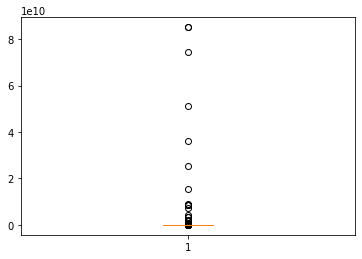

In [24]:
plt.boxplot(df_trans['amount_usd'])
plt.show()

In [25]:
# Let's check the 10th percentile for the lower values and the 90th percentile for the higher values.
print("10th percentile: ", df_trans['amount_usd'].quantile(0.1))
print("90th percentile: ", df_trans['amount_usd'].quantile(0.90))

# check median
print("Median: ", df_trans['amount_usd'].median())

10th percentile:  0.72
90th percentile:  65.52
Median:  7.24


However if we drop the above percentiles then we drop 20% of the data which is a lot let's check the 5th and the 95th percentile

In [26]:
print("5th percentile: ", df_trans['amount_usd'].quantile(0.05))
print("95th percentile: ", df_trans['amount_usd'].quantile(0.95))

5th percentile:  0.33
95th percentile:  132.38


Before cleaning:  2139234
After cleaning:  1926190
Still skewed?:  2.4958591497213303
Median:  7.23


,amount_usd
count,1.926190e+06
mean,1.620349e+01
std,2.296530e+01
min,3.300000e-01
25%,2.630000e+00
50%,7.230000e+00
75%,1.864000e+01
max,1.323800e+02


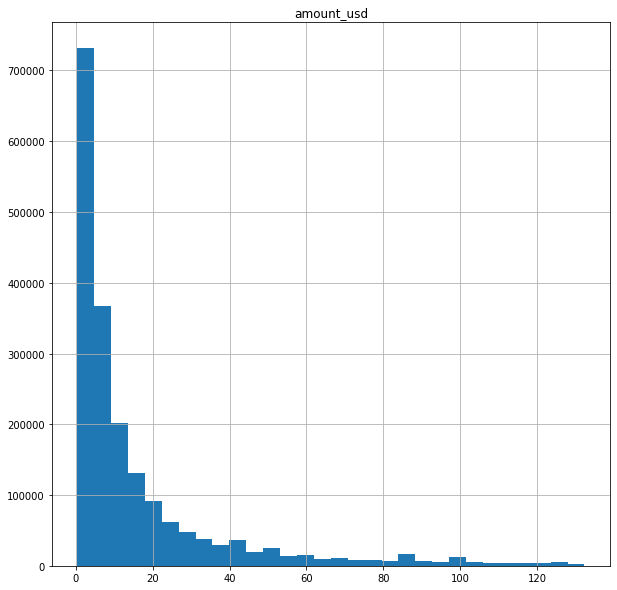

In [27]:
# Now we will remove the outliers 
print("Before cleaning: ", len(df_trans))
df_trans = df_trans[(df_trans['amount_usd'] >= 0.33) & (df_trans['amount_usd'] <= 132.38)]
print("After cleaning: ", len(df_trans))
print("Still skewed?: ", df_trans['amount_usd'].skew())
# check median
print("Median: ", df_trans['amount_usd'].median())

show_me_basic_stats(df_trans, cols_to_exclude=['user_id', 'transaction_id', 'created_date','ea_merchant_mcc'], only_histograms=True)

In [28]:
# Fix currency
df_trans['transactions_currency_grouped'] = 'Other_currency'
df_trans.loc[df_trans['transactions_currency']=='GBP', 'transactions_currency_grouped'] = 'GBP'
df_trans.loc[df_trans['transactions_currency']=='EUR', 'transactions_currency_grouped'] = 'EUR'

df_trans = df_trans.join(pd.get_dummies(df_trans[['transactions_currency_grouped', 'transactions_type']]))
df_trans_user_lvl = df_trans.groupby(['user_id']).sum()

In [29]:
# average per month
df_trans_usd_pm = df_trans.set_index('created_date')
df_trans_usd_pm = df_trans_usd_pm.groupby(['user_id',pd.Grouper(freq='M')]).transaction_id.nunique().reset_index().groupby(['user_id']).mean()
df_trans_usd_pm.columns = ['amoun_usd_pm']

# merge data
print(len(df_trans_user_lvl))
print(len(df_trans_usd_pm))
df_trans_user_lvl = df_trans_user_lvl.join(df_trans_usd_pm)
print(len(df_trans_user_lvl))

17677
17677
17677


##### -------------- Users ---------------------------- 

In [30]:
# check level of uniqueness - it's already in user level as expected
print(len(df_users))
print(df_users['user_id'].nunique())
df_users.isna().sum()

19430
19430


user_id                                        0
birth_year                                     0
country                                        0
city                                           0
created_date                                   0
user_settings_crypto_unlocked                  0
plan                                           0
attributes_notifications_marketing_push     6610
attributes_notifications_marketing_email    6610
num_contacts                                   0
num_referrals                                  0
num_successful_referrals                       0
dtype: int64

In [31]:
# create variable days with revolut
df_users['today'] = pd.to_datetime(date.today())
df_users['created_date'] = pd.to_datetime(df_users['created_date'])
df_users['life_duration'] = (df_users['today'] - df_users['created_date']).dt.days

df_users.drop(columns=['today', 'created_date'], inplace=True)

In [32]:
## fix birthday
df_users['birth_year'] = pd.to_datetime(date.today()).year - df_users['birth_year']

df_users['Age'] = 'over 55'
df_users.loc[df_users['birth_year'].between(18, 25, inclusive=True), 'Age'] = '18-25'
df_users.loc[df_users['birth_year'].between(26, 35, inclusive=True), 'Age'] = '26-35'
df_users.loc[df_users['birth_year'].between(36, 45, inclusive=True), 'Age'] = '36-45'
df_users.loc[df_users['birth_year'].between(46, 55, inclusive=True), 'Age'] = '46-55'

df_users.drop(columns='birth_year', inplace=True)

##### -------------- Merge data ---------------------------- 

In [33]:
# Merge all data together
df_all_data = df_users.set_index('user_id').join(df_devices.set_index('user_id'), how='left').join(df_trans_user_lvl, how='left').join(df_notif_user_lvl, how='left')
print(len(df_users))
print(len(df_all_data))

# drop columns that we decided in the previous step that are not inforamtive
df_all_data.drop(columns=['num_referrals', 'num_successful_referrals', 'city'], inplace=True)

# lets append the target variable as well
df_all_data = df_all_data.join(df_trans_pm['Target'], how='left')

# let's fill all nans with 0 as all our features are numeric, and actuallythe only nans come fromthe marketing permissions 
# where we'll interpret null as the person hasn't given permission
df_all_data.fillna(0, inplace=True)

19430
19430


We have the feature set and before starting modelling, let's check the relationship between the features and our target variable.

Interestingly we see that engaged users appear:
- Fairly evenly distributed geographically
- More likely to be below 45
- More likely to have a more expensive plan
- More likely tohave crypt0 unlock
- life_duration is higher for more engaged people
- They appear to do more transactions irrespecively of the type(ATM, CARS, FEE payments)
-  They appera to engage more with ENGAGEMENT_SPLIT_BILL_RESTAURANT notifications, they seem to have same behaviour to the notifications, whic

Target,False,True
country,,
AT,0.004593,0.003341
AU,0.000478,0.000111
BE,0.009187,0.005234
BG,0.007368,0.001893
CH,0.024498,0.020824
CY,0.011866,0.007461
CZ,0.018947,0.017483
DE,0.028995,0.015924
DK,0.005837,0.004454


Target,False,True
plan,,
METAL,0.009856,0.044989
METAL_FREE,0.000861,0.003118
PREMIUM,0.029665,0.061804
PREMIUM_FREE,0.000000,0.000445
PREMIUM_OFFER,0.000670,0.002004
STANDARD,0.958947,0.887639


Target,False,True
Age,,
18-25,0.132919,0.168263
26-35,0.388230,0.458352
36-45,0.245646,0.221826
46-55,0.131962,0.101336
over 55,0.101244,0.050223


Target,False,True
brand,,
Android,0.519330,0.477394
Apple,0.479713,0.518931
Unknown,0.000957,0.003675


user_settings_crypto_unlocked


Target,False,True
user_settings_crypto_unlocked,,
0,0.856077,0.775835
1,0.143923,0.224165


attributes_notifications_marketing_push


Target,False,True
attributes_notifications_marketing_push,,
0.0,0.362679,0.388864
1.0,0.637321,0.611136


attributes_notifications_marketing_email


Target,False,True
attributes_notifications_marketing_email,,
0.0,0.399234,0.420045
1.0,0.600766,0.579955


num_contacts


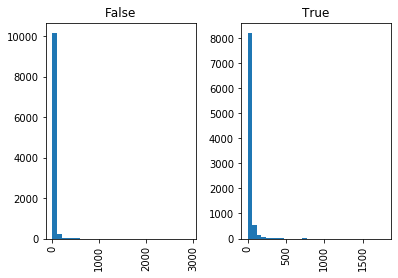

life_duration


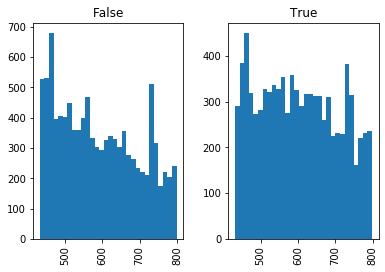

amount_usd


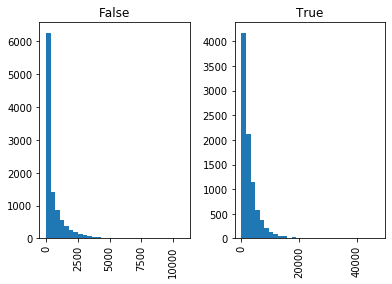

ea_merchant_mcc


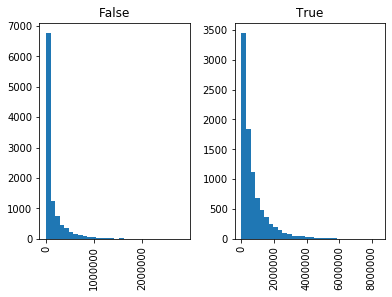

transactions_currency_grouped_EUR


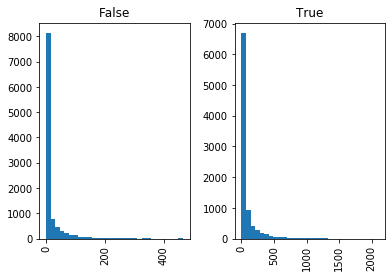

transactions_currency_grouped_GBP


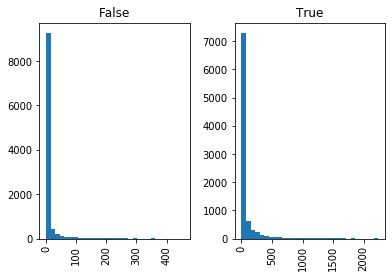

transactions_currency_grouped_Other_currency


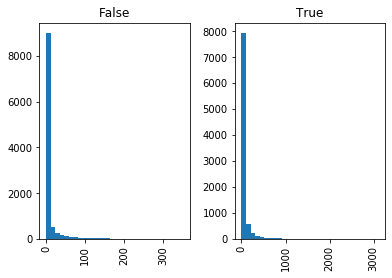

transactions_type_ATM


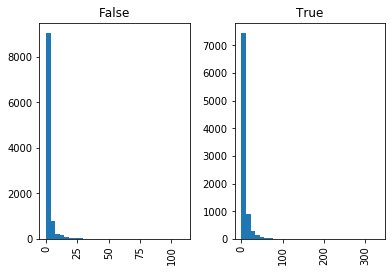

transactions_type_CARD_PAYMENT


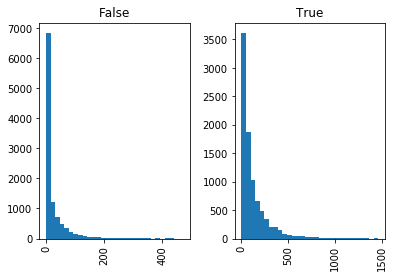

transactions_type_EXCHANGE


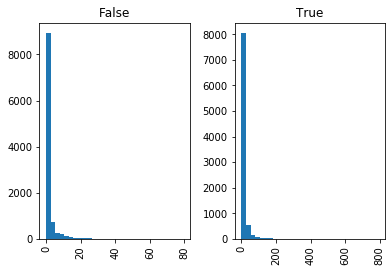

transactions_type_FEE


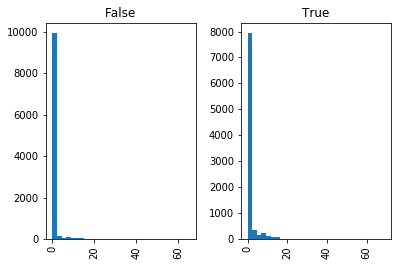

transactions_type_TRANSFER


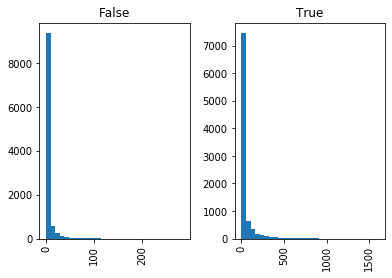

amoun_usd_pm


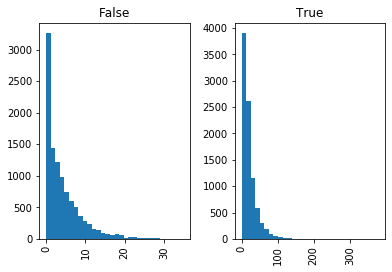

BLACK_FRIDAY


Target,False,True
BLACK_FRIDAY,,
0.0,0.974928,0.829176
1.0,0.025072,0.170824


ENGAGEMENT_SPLIT_BILL_RESTAURANT


Target,False,True
ENGAGEMENT_SPLIT_BILL_RESTAURANT,,
0.0,0.97244,0.852673
1.0,0.02756,0.147327


FIFTH_PAYMENT_PROMO


Target,False,True
FIFTH_PAYMENT_PROMO,,
0.0,0.519330,0.414922
1.0,0.186220,0.252227
2.0,0.261435,0.296437
3.0,0.033014,0.036414


JOINING_ANNIVERSARY


Target,False,True
JOINING_ANNIVERSARY,,
0.0,0.834833,0.81314
1.0,0.165167,0.18686


LOST_CARD_ORDER


Target,False,True
LOST_CARD_ORDER,,
0.0,0.837608,0.864031
1.0,0.093780,0.073163
2.0,0.065167,0.060579
3.0,0.002105,0.001336
4.0,0.001340,0.000891


MADE_MONEY_REQUEST_NOT_SPLIT_BILL


Target,False,True
MADE_MONEY_REQUEST_NOT_SPLIT_BILL,,
0.0,0.944593,0.882405
1.0,0.055407,0.117595


METAL_GAME_START


Target,False,True
METAL_GAME_START,,
0.0,0.662584,0.629065
1.0,0.337416,0.370935


METAL_RESERVE_PLAN


Target,False,True
METAL_RESERVE_PLAN,,
0.0,0.995215,0.984855
1.0,0.000287,0.000668
3.0,0.000287,0.001559
4.0,0.004211,0.012918


NO_INITIAL_CARD_ORDER


Target,False,True
NO_INITIAL_CARD_ORDER,,
0.0,0.610431,0.677394
1.0,0.325933,0.266815
2.0,0.050909,0.043207
3.0,0.011196,0.011024
4.0,0.001435,0.001336
5.0,0.000096,0.000223


NO_INITIAL_CARD_USE


Target,False,True
NO_INITIAL_CARD_USE,,
0.0,0.774833,0.824610
1.0,0.151770,0.135412
2.0,0.048134,0.028842
3.0,0.020383,0.009577
4.0,0.004880,0.001559


NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER


Target,False,True
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER,,
0.0,0.827177,0.912584
1.0,0.045837,0.033408
2.0,0.116077,0.048218
3.0,0.010909,0.005791


ONBOARDING_TIPS_ACTIVATED_USERS


Target,False,True
ONBOARDING_TIPS_ACTIVATED_USERS,,
0.0,0.976268,0.942539
1.0,0.001435,0.002784
2.0,0.001627,0.003118
3.0,0.001722,0.005011
4.0,0.018947,0.046548


PREMIUM_ENGAGEMENT_FEES_SAVED


Target,False,True
PREMIUM_ENGAGEMENT_FEES_SAVED,,
0.0,0.993780,0.969599
1.0,0.004211,0.016815
2.0,0.001340,0.009243
3.0,0.000478,0.002673
4.0,0.000191,0.001225
5.0,0.000000,0.000334
6.0,0.000000,0.000111


PREMIUM_ENGAGEMENT_INACTIVE_CARD


Target,False,True
PREMIUM_ENGAGEMENT_INACTIVE_CARD,,
0.0,0.973684,0.969822
1.0,0.009378,0.015590
2.0,0.008804,0.008909
3.0,0.008134,0.005679


PUMPKIN_PAYMENT_NOTIFICATION


Target,False,True
PUMPKIN_PAYMENT_NOTIFICATION,,
0.0,0.984306,0.966147
1.0,0.013971,0.028508
2.0,0.001722,0.005345


REENGAGEMENT_ACTIVE_FUNDS


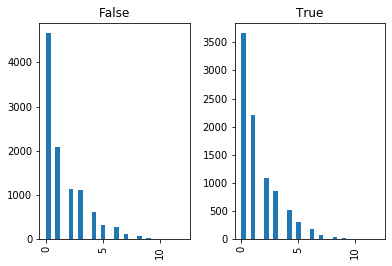

WELCOME_HOME


Target,False,True
WELCOME_HOME,,
0.0,0.973014,0.951002
1.0,0.026986,0.048998


EMAIL


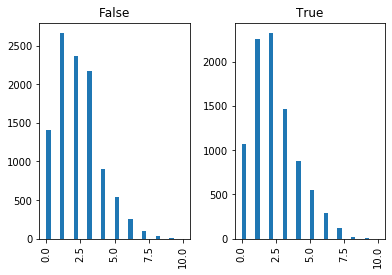

PUSH


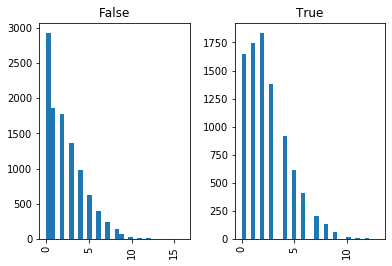

SMS


Target,False,True
SMS,,
0.0,0.978756,0.972049
1.0,0.016746,0.013474
3.0,0.000287,0.001559
4.0,0.004115,0.012695
5.0,0.000096,0.000223


In [34]:
for column in df_all_data.select_dtypes(include=['object']).columns:
    if column != 'Target':
        display(pd.crosstab(index=df_all_data[column], columns=df_all_data['Target'], normalize='columns'))

for column in df_all_data.select_dtypes(exclude=['object']).columns:
    print(column)
    if df_all_data[column].nunique()>10:
        hist = df_all_data[[column, 'Target']].hist(by='Target', bins=30)
        plt.show()
    else:
        display(pd.crosstab(index=df_all_data[column], columns=df_all_data['Target'], normalize='columns'))

In [35]:
# clean data
del df_devices, df_notif, df_notif_user_lvl, df_notif_user_lvl_channel, df_notif_user_lvl_reason, df_trans, df_trans_pm, df_trans_usd_pm, df_trans_user_lvl, df_users

In [36]:
cols_to_exclude_from_plot = ['BLACK_FRIDAY', 'ENGAGEMENT_SPLIT_BILL_RESTAURANT',
 'FIFTH_PAYMENT_PROMO', 'JOINING_ANNIVERSARY',
 'LOST_CARD_ORDER', 'MADE_MONEY_REQUEST_NOT_SPLIT_BILL', 'METAL_GAME_START',
 'METAL_RESERVE_PLAN', 'NO_INITIAL_CARD_ORDER', 'NO_INITIAL_CARD_USE', 'NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER',
 'ONBOARDING_TIPS_ACTIVATED_USERS', 'PREMIUM_ENGAGEMENT_FEES_SAVED', 'PREMIUM_ENGAGEMENT_INACTIVE_CARD',
 'PUMPKIN_PAYMENT_NOTIFICATION', 'REENGAGEMENT_ACTIVE_FUNDS', 'WELCOME_HOME']

,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,life_duration,amount_usd,ea_merchant_mcc,transactions_currency_grouped_EUR,transactions_currency_grouped_GBP,transactions_currency_grouped_Other_currency,transactions_type_ATM,transactions_type_CARD_PAYMENT,transactions_type_EXCHANGE,transactions_type_FEE,transactions_type_TRANSFER,amoun_usd_pm,BLACK_FRIDAY,ENGAGEMENT_SPLIT_BILL_RESTAURANT,FIFTH_PAYMENT_PROMO,JOINING_ANNIVERSARY,LOST_CARD_ORDER,MADE_MONEY_REQUEST_NOT_SPLIT_BILL,METAL_GAME_START,METAL_RESERVE_PLAN,NO_INITIAL_CARD_ORDER,NO_INITIAL_CARD_USE,NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER,ONBOARDING_TIPS_ACTIVATED_USERS,PREMIUM_ENGAGEMENT_FEES_SAVED,PREMIUM_ENGAGEMENT_INACTIVE_CARD,PUMPKIN_PAYMENT_NOTIFICATION,REENGAGEMENT_ACTIVE_FUNDS,WELCOME_HOME,EMAIL,PUSH,SMS
user_settings_crypto_unlocked,1.000000,0.250766,0.250128,0.036495,0.116441,0.192032,0.170119,0.141374,0.083121,0.127423,0.105615,0.165594,0.153254,0.198631,0.171297,0.167496,0.066877,0.072904,0.038535,0.066055,-0.021482,0.086214,0.000790,0.080476,0.032369,0.004060,-0.059778,0.031526,0.116404,0.162982,0.069608,-0.000617,0.000927,0.040468,0.070368,0.071543
attributes_notifications_marketing_push,0.250766,1.000000,0.913457,0.051518,-0.010492,0.009904,0.013030,0.044504,-0.017676,0.033108,-0.007025,0.013574,0.028542,-0.016965,0.057532,0.014562,0.040052,0.003768,-0.078820,-0.026080,-0.025312,0.061955,-0.039853,0.039197,0.201352,-0.086820,0.272215,-0.061643,0.018268,-0.011310,0.047115,-0.036470,0.008764,0.089023,-0.038078,0.029845
attributes_notifications_marketing_email,0.250128,0.913457,1.000000,0.057837,-0.023882,0.020673,0.020128,0.048861,-0.009789,0.034292,-0.001070,0.020136,0.037602,-0.009112,0.063943,0.023184,0.042035,0.023409,-0.042093,-0.036701,-0.011688,0.073337,0.004053,0.037429,0.187142,-0.074283,0.271451,-0.054233,0.019153,-0.008992,0.043643,-0.032421,0.024458,0.133562,-0.033301,0.026911
num_contacts,0.036495,0.051518,0.057837,1.000000,-0.066180,0.115478,0.092414,0.132993,-0.016405,0.085737,0.039188,0.093119,0.037249,0.021378,0.119118,0.118811,0.036424,0.101879,0.027999,-0.034857,0.062760,0.165382,-0.005532,0.012407,-0.016650,0.026546,0.003351,0.008403,0.006324,-0.014489,0.048773,-0.015350,0.038335,0.073372,0.005266,0.008530
life_duration,0.116441,-0.010492,-0.023882,-0.066180,1.000000,0.197941,0.174572,0.101448,0.101821,0.075273,0.131410,0.169404,0.103743,0.119432,0.071356,0.023758,0.225066,0.011322,0.060654,0.577203,-0.354831,0.004873,-0.022510,0.061582,0.122006,-0.066006,-0.214377,-0.077293,0.055566,0.112995,0.064654,0.220420,0.033155,-0.112873,0.291385,0.079898
amount_usd,0.192032,0.009904,0.020673,0.115478,0.197941,1.000000,0.859940,0.558122,0.517049,0.408978,0.548098,0.843749,0.442689,0.269539,0.582253,0.781262,0.411256,0.388997,0.090103,0.117403,-0.069775,0.203380,-0.003419,0.087348,-0.059394,-0.098468,-0.133961,0.118296,0.270554,0.035544,0.122101,-0.063897,0.043622,0.065525,0.072464,0.079154
ea_merchant_mcc,0.170119,0.013030,0.020128,0.092414,0.174572,0.859940,1.000000,0.576254,0.602494,0.440806,0.512640,0.995067,0.348562,0.232598,0.557341,0.862636,0.471760,0.379769,0.083594,0.102312,-0.077348,0.199945,0.008865,0.099690,-0.063529,-0.112501,-0.122411,0.103916,0.198751,0.000518,0.123371,-0.096455,0.018719,0.051463,0.035130,0.088963
transactions_currency_grouped_EUR,0.141374,0.044504,0.048861,0.132993,0.101448,0.558122,0.576254,1.000000,-0.014364,0.016438,0.301065,0.566357,0.185430,0.126518,0.520660,0.554239,0.311759,0.232975,0.054899,0.061185,-0.044064,0.200306,-0.003000,0.076654,-0.031569,-0.062003,-0.073338,0.043155,0.120366,-0.005894,0.110362,-0.063422,0.001992,0.038639,0.025023,0.068276
transactions_currency_grouped_GBP,0.083121,-0.017676,-0.009789,-0.016405,0.101821,0.517049,0.602494,-0.014364,1.000000,-0.017636,0.345648,0.606013,0.232351,0.176599,0.467457,0.565216,0.272751,0.229776,0.054979,0.061539,-0.048144,0.057750,0.011091,0.061675,-0.033719,-0.060889,-0.065192,0.088716,0

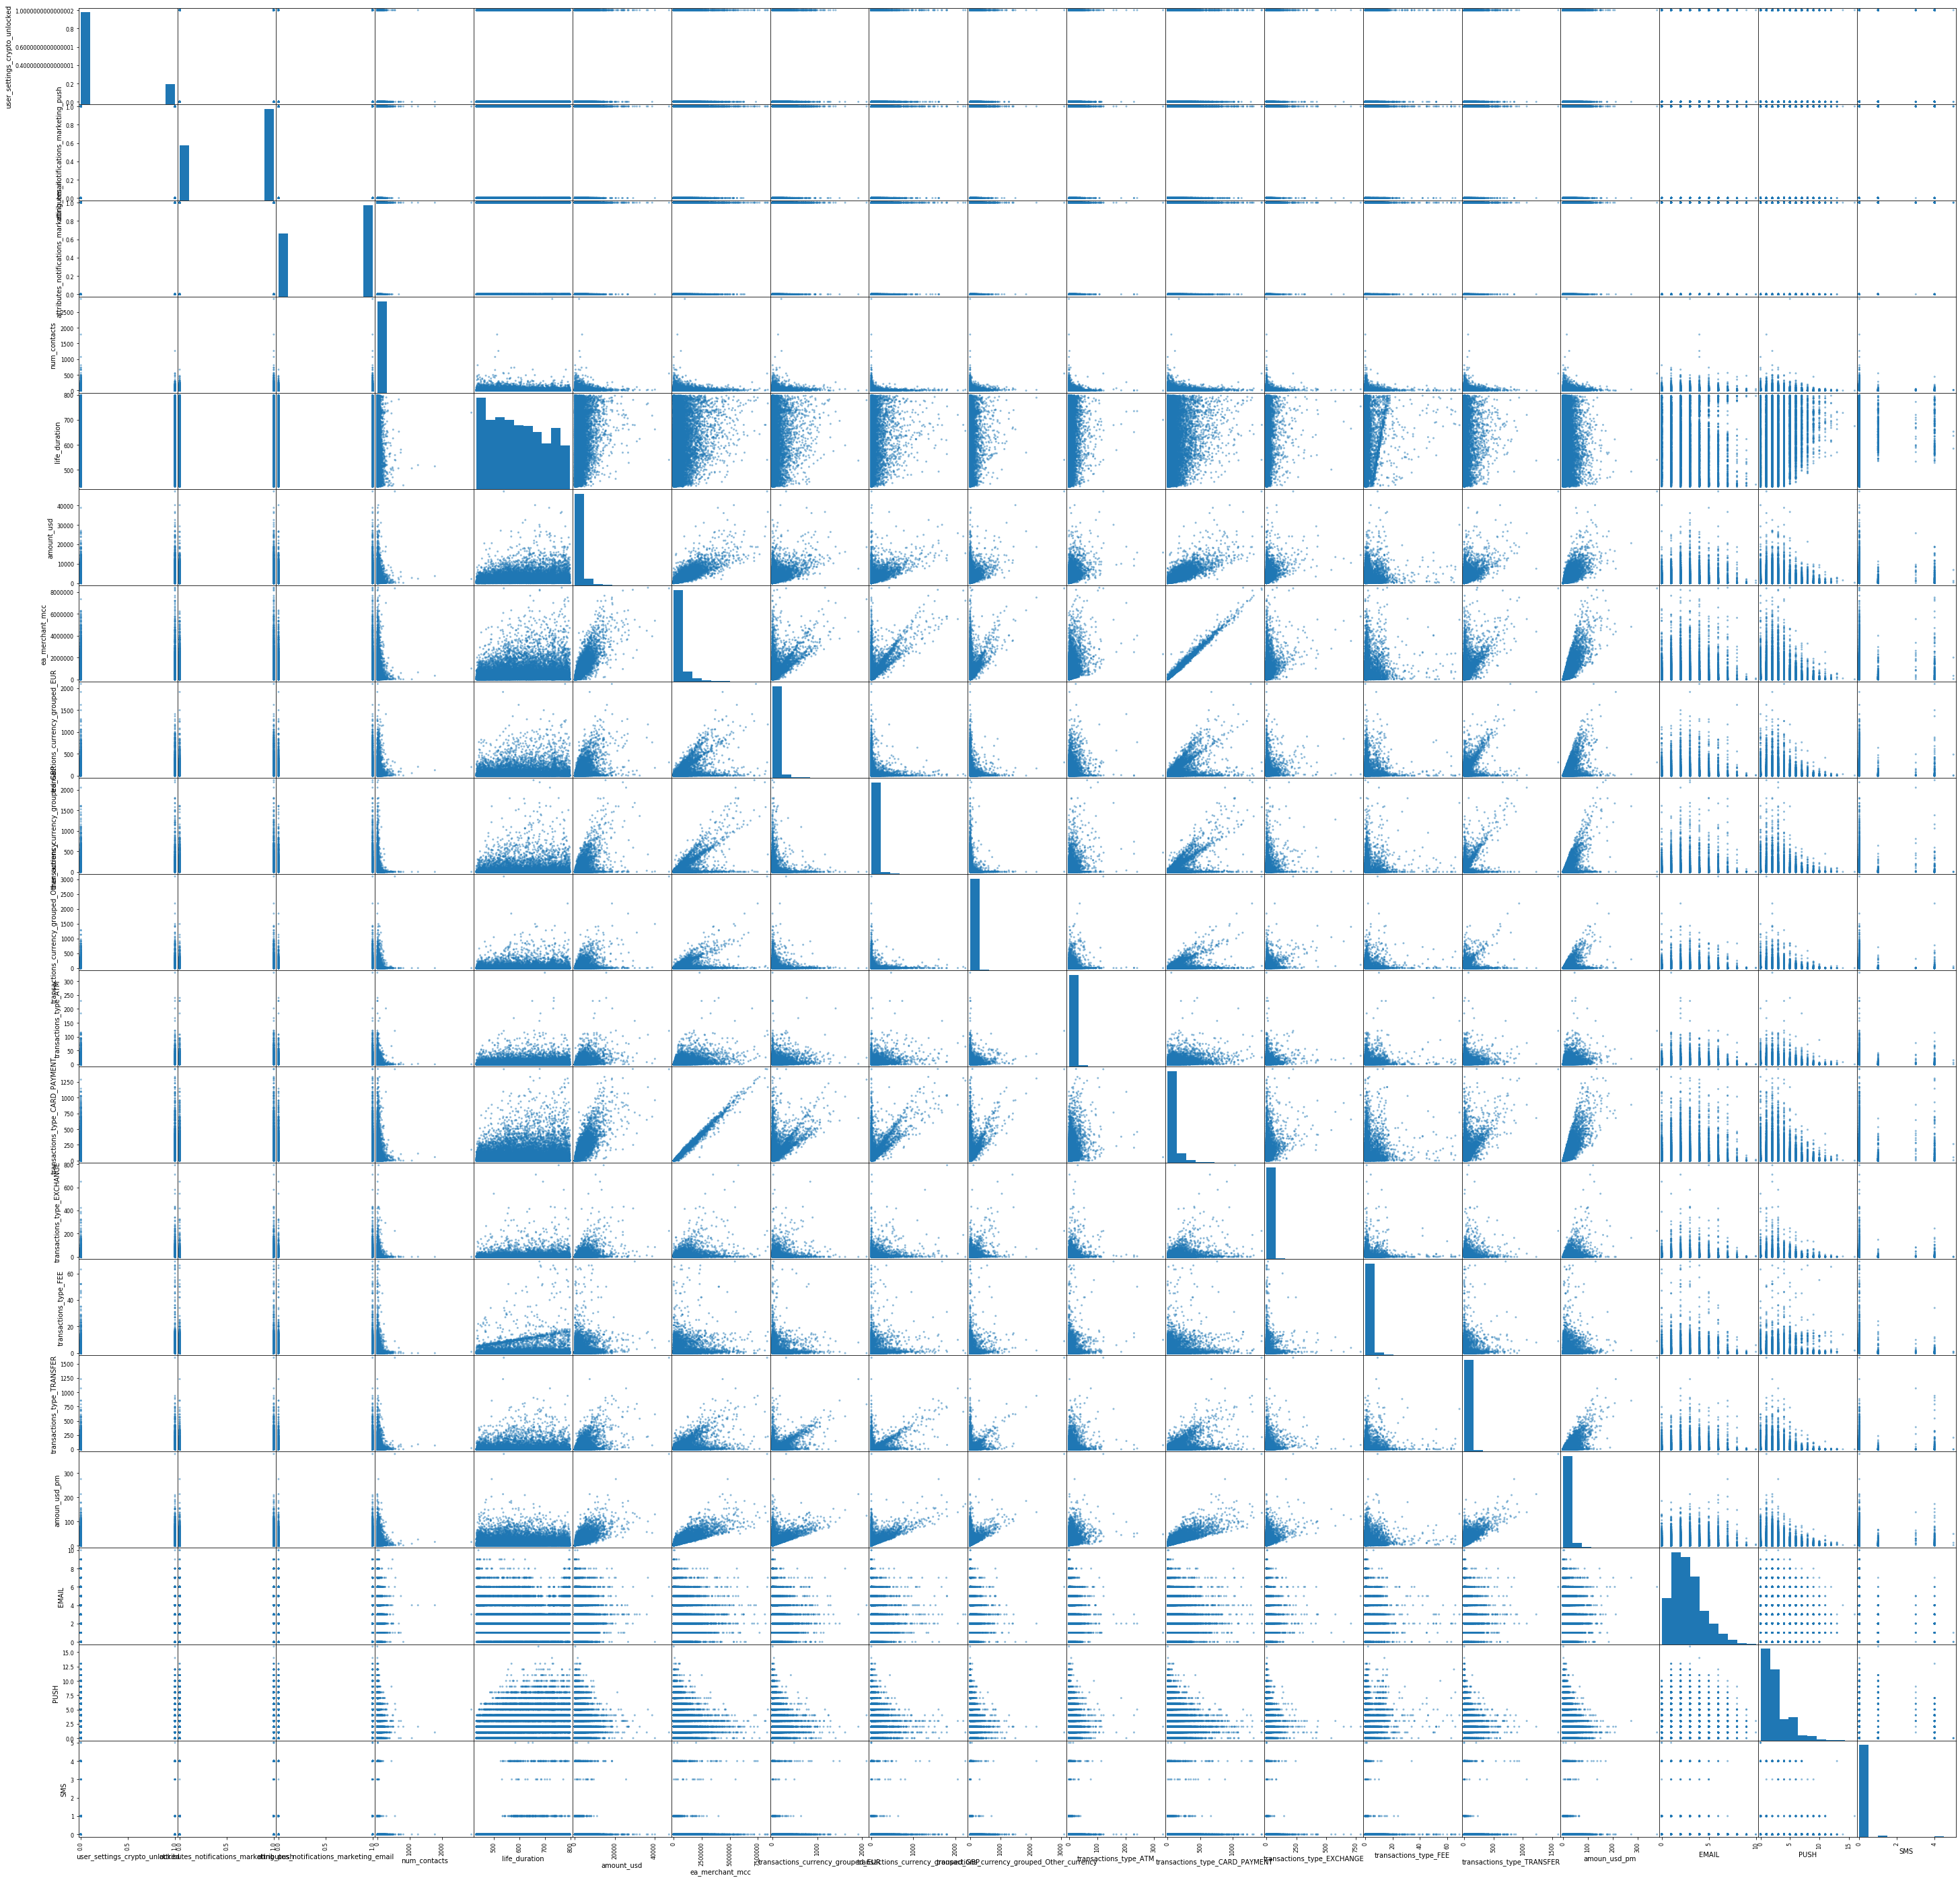

In [37]:
# check correlations between variables

display(df_all_data.corr())
pd.plotting.scatter_matrix(df_all_data.loc[:,~df_all_data.columns.isin(cols_to_exclude_from_plot)], figsize=(50, 50))
plt.show()

We see several features are higly correlated:
- attributes_notifications_marketing_email and  attributes_notifications_marketing_push clean
- transactions_type_CARD_PAYMENT and amount usd clean 
- transactions_type_CARD_PAYMENT and ea_merchant_mcc usd clean
- ea_merchant_mcc and amount_usd clean
- amount_usd_pm and amount_usd
- amount_usd_pm and ea_merchant_mcc
    
Let's remove one feature from each of the highly correlated pairs: 
'transactions_type_CARD_PAYMENT'
'ea_merchant_mcc'
'attributes_notifications_marketing_push'
'amount_usd' as we have the usd per month inside that capures time as well

In [38]:
df_all_data.drop(columns=['transactions_type_CARD_PAYMENT', 'ea_merchant_mcc', 'attributes_notifications_marketing_push','amount_usd'], inplace=True)

Now that we've cleaned up our dataset, let's determine which algorithm to use. 
As we want to predict if someone is engaged or not, we just have a binary classification model and we're going to use an xbooost model.

In [39]:
# convert our categorical features into numeric features.
model_data = pd.get_dummies(df_all_data)
model_data = model_data.drop(['Target_True'], axis=1) # drop the true as we want to predict who is going to churn not who is engaged

In [40]:
# clean all previous data
del df_all_data

In [41]:
target_col = 'Target_False'

# shuffle data
model_data = shuffle(model_data)
model_data.reset_index(drop=True, inplace=True)

print("Data length: ",len(model_data))
print("Engaged users: ",model_data[target_col].sum())

# Sanity check for missing values
print("Null values on data? ",model_data.isnull().values.any())

Data length:  19430
Engaged users:  10450
Null values on data?  False


In [ ]:
# Split dataset to train and test
train, test = train_test_split(model_data, test_size=0.3, random_state=123)

# split the train to a smaller train and validation set
train, validation = train_test_split(train, test_size=0.15, random_state=123)

# Separate target from feature columns for train, val an test set
target_idx = train.columns.get_loc(target_col)
X_train = train.loc[:, train.columns != target_col]
Y_train = train[train.columns[target_idx]]

X_validation = validation.loc[:, validation.columns != target_col]
Y_validation = validation[validation.columns[target_idx]]

X_test = test.loc[:, test.columns != target_col]
Y_test = test[test.columns[target_idx]]

# Normalise data
X_train = normalise_data(X_train)
X_validation = normalise_data(X_validation)
X_test = normalise_data(X_test)

# check performance of the optimised parameters
data_dmatrix = xgb.DMatrix(data=X_train, label=Y_train)
validation_matrix = xgb.DMatrix(data=X_validation, label=Y_validation)
test_matrix=xgb.DMatrix(data=X_test, label=Y_test)

params = {"eval_metric": "error",
          "objective": "binary:logistic"}

bst = xgb.train(params, data_dmatrix)


# plot feature importance and save plot
ax = plot_importance(bst, max_num_features=20, importance_type='weight')
ax.figure.savefig('../data/features.png')

# save model
#bst.save_model('../models/xbt_sport_xgboost_sample_21012020.model')

# Create confusion matrix for validation set
valid_y_pred = bst.predict(validation_matrix)
valid_y_pred[valid_y_pred > 0.50] = 1
valid_y_pred[valid_y_pred <= 0.50] = 0

# print validation measures
print("Validation set")
print("Recall:", recall_score(Y_validation, valid_y_pred))
print("Precision:", precision_score(Y_validation, valid_y_pred))
print("Acuracy:", accuracy_score(Y_validation,valid_y_pred))
print("F1: ", f1_score(Y_validation, valid_y_pred))
print(confusion_matrix(Y_validation, valid_y_pred))

# Create confusion matrix for test set
test_y_pred = bst.predict(test_matrix)
test_y_pred[test_y_pred > 0.50] = 1
test_y_pred[test_y_pred <= 0.50] = 0

# print test measures
print("Test set")
print("Recall:",recall_score(Y_test, test_y_pred))
print("Precision:",precision_score(Y_test, test_y_pred))
print("Acuracy:",accuracy_score(Y_test,test_y_pred))
print("F1: ",f1_score(Y_test,test_y_pred))
print(confusion_matrix(Y_test, test_y_pred))

# Deciles
test_y_pred = bst.predict(test_matrix)
test_y_pred_decils = array_to_deciles(test_y_pred)
counts = pd.value_counts(test_y_pred_decils)
is_engaged = Y_test == 1

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_engaged[test_y_pred_decils == prob])
    true_prob = pd.Series(true_prob)

counts_pandas = pd.concat([counts, true_prob], axis=1).reset_index()
counts_pandas.columns = ['pred_prob', 'count', 'true_prob']
counts_pandas.sort_values(by=['pred_prob'], inplace=True)
counts_pandas.to_csv("../data/deciles.csv")


--RESULTS--

Validation set
Recall: 0.7146788990825688
Precision: 0.8674832962138085
Acuracy: 0.7893189612934836
F1:  0.783702213279678
[[832 119]
 [311 779]]
Test set
Recall: 0.9274116523400191
Precision: 0.7419765664798778
Acuracy: 0.787098987819523
F1:  0.8243950757039762
[[1675 1013]
 [ 228 2913]]



The performance of our model in the test set is as good as in the validation set, so we can say that we haven't overfitted.
Also our model performs better than random (random guess = 0.54 <<0.787 accuracy on test set)

To improve the model:
 - tune the parameters of the model
 - play with the features
 - adjust the cutt off threshold

 
Of the 3141 churners, we've correctly predicted 2913 of them (true positives). And, we incorrectly predicted 1013 customers would churn who then ended up not doing so (false positives).  There are also 228 customers who ended up churning, that we predicted would not (false negatives).

A customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting the threshold of the probability so the we minimise the false negatives.

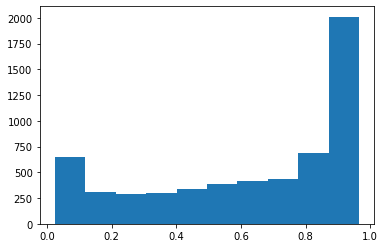

In [47]:
plt.hist(test_y_pred)
plt.show()

In [55]:
# play a bitwith the cut off
pd.crosstab(index=Y_test, columns=np.where(test_y_pred > 0.3, 1, 0))

col_0,0,1
Target_False,,
0,1176,1512
1,55,3086


### a. How would you set up a test/experiment to check whether we are actually  reducing churn?  

First step: 
1. work with the stakeholders to define what these business actions should be. Given the fact that know the data
we could advice on what these actions should be

Second step:
It depends how many actions we apply and if they need to have a chronological order or not. 
Let's assume for simplicity that we're applying only one business action at a time which is independent of all the other actions that are going to follow. In that case:
2. We'll apply the model to the whole base of our customers
3. For those that the model predicted as high risk churners we're going to split them in 2 groups, test and control.
4. the control is not going to recieve any of the actions where the test is going to receive it.
5. In a frequency that makes sense based on the pre defined business actions (like weekly, monthly...), we are going to check the churn rate on the test segment vs the control. If churn rate is better in the test vs the control then we're happy! 

### b. What metrics and techniques would you use to assess the impact of the business  action? 

For every user that recieved the action we're going to monitor his/her behaviour. For example if we're pushing a notification about “Rev Rally” event then metrics like click through rate may be used or actually presence at the event. Then, check if the higher click through rate is actually reducing churn or not. Since we have scored the whole base, we can know ho the model predicted as churners, who actually churned and who responded o the business action.